In [39]:
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate, Dropout
import tensorflow as tf
import kerastuner as kt
from itertools import product
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt 
import numpy as np

# Tune U-net model on real data

In [2]:
def get_model(optimizer, learning_rate, dropout_rate):
    INPUT_SIZE = (256, 256, 1)

    # Contracting path
    inputs = Input(shape=INPUT_SIZE)
    conv1 = Conv2D(filters=64, kernel_size=3, activation='relu',
                padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1=Conv2D(filters = 64, kernel_size = 3, activation = 'relu',
                padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1=MaxPool2D(pool_size = 2)(conv1)

    conv2=Conv2D(filters = 128, kernel_size = 3, activation = 'relu',
                padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2=Conv2D(filters = 128, kernel_size = 3, activation = 'relu',
                padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2=MaxPool2D(pool_size = 2)(conv2)

    conv3=Conv2D(filters = 256, kernel_size = 3, activation = 'relu',
                padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3=Conv2D(filters = 256, kernel_size = 3, activation = 'relu',
                padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3=MaxPool2D(pool_size = 2)(conv3)

    conv4=Conv2D(filters = 512, kernel_size = 3, activation = 'relu',
                padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4=Conv2D(filters = 512, kernel_size = 3, activation = 'relu',
                padding = 'same', kernel_initializer = 'he_normal')(conv4)
    # Drop out layers are not present in the diagram of U-net architecture,
    # but it is mentioned in paper https://arxiv.org/pdf/1505.04597v1.pdf,
    # that there are placed at the end of the contracting path.
    drop4=Dropout(dropout_rate)(conv4)
    pool4=MaxPool2D(pool_size = 2)(drop4)

    conv5=Conv2D(filters = 1024, kernel_size = 3, activation = 'relu',
                padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5=Conv2D(filters = 1024, kernel_size = 3, activation = 'relu',
                padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5=Dropout(dropout_rate)(conv5)

    # Expanding path
    up6=UpSampling2D(size = 2)(drop5)
    up6=Conv2D(filters = 512, kernel_size = 2, activation = 'relu', padding = 'same',
                kernel_initializer = 'he_normal')(up6)
    copy6=Concatenate(axis = 3)([drop4, up6])
    conv6=Conv2D(filters = 512, kernel_size = 3, activation = 'relu', padding = 'same',
                kernel_initializer = 'he_normal')(copy6)
    conv6=Conv2D(filters = 512, kernel_size = 3, activation = 'relu', padding = 'same',
                kernel_initializer = 'he_normal')(conv6)

    up7=UpSampling2D(size = 2)(conv6)
    up7=Conv2D(filters = 256, kernel_size = 2, activation = 'relu', padding = 'same',
                kernel_initializer = 'he_normal')(up7)
    copy7=Concatenate(axis = 3)([conv3, up7])
    conv7=Conv2D(filters = 256, kernel_size = 3, activation = 'relu', padding = 'same',
                kernel_initializer = 'he_normal')(copy7)
    conv7=Conv2D(filters = 256, kernel_size = 3, activation = 'relu', padding = 'same',
                kernel_initializer = 'he_normal')(conv7)

    up8=UpSampling2D(size = 2)(conv7)
    up8=Conv2D(filters = 128, kernel_size = 2, activation = 'relu', padding = 'same',
                kernel_initializer = 'he_normal')(up8)
    copy8=Concatenate(axis = 3)([conv2, up8])
    conv8=Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same',
                kernel_initializer = 'he_normal')(copy8)
    conv8=Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same',
                kernel_initializer = 'he_normal')(conv8)

    up9=Conv2D(filters = 64, kernel_size = 2, activation = 'relu', padding = 'same',
                kernel_initializer = 'he_normal')(UpSampling2D(size=(2, 2))(conv8))
    copy9=Concatenate(axis = 3)([conv1, up9])
    conv9=Conv2D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same',
                kernel_initializer = 'he_normal')(copy9)
    conv9=Conv2D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same',
                kernel_initializer = 'he_normal')(conv9)
    conv9=Conv2D(filters = 2, kernel_size = 3, activation = 'relu', padding = 'same',
                kernel_initializer = 'he_normal')(conv9)
    conv10=Conv2D(filters = 1, kernel_size = 1, activation = 'sigmoid')(conv9)

    model=Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss = 'binary_crossentropy',
                 metrics = [tf.keras.metrics.MeanIoU])
    model.summary()

    return model

In [3]:
HYPERPARAMETERS = {
    'batch_size': [8, 16, 32, 64],
    'optimizer': [tf.keras.optimizers.Adam, tf.keras.optimizers.Adagrad, tf.keras.optimizers.SGD],
    'learning_rate': [1e-2, 1e-3, 1e-4],
    'dropout_rate': [i/10 for i in range(6)]
}

### Data generator is used in order not to store all images and segmentation masks in memory at once

In [45]:
# Normalilze [-1, 1] input images
def preprocess_image(img):
    img = (img - 127.5) / 127.5
    return img

# Make mask a binary mask
def preprocess_mask(mask):
    mask[mask > 0] = 1
    return mask

In [46]:
image_generator = ImageDataGenerator(
    preprocessing_function=preprocess_image)
mask_generator = ImageDataGenerator(
    preprocessing_function=preprocess_mask)

Found 2594 images belonging to 1 classes.
Found 2594 images belonging to 1 classes.


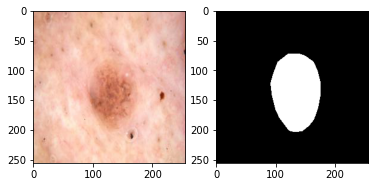

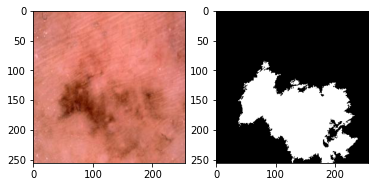

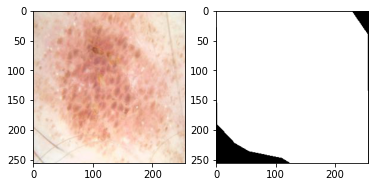

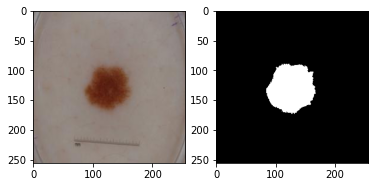

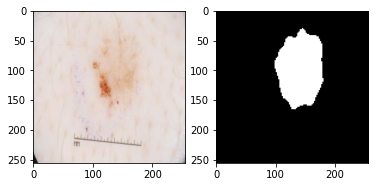

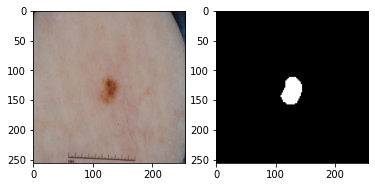

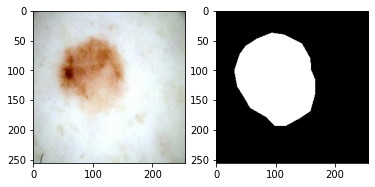

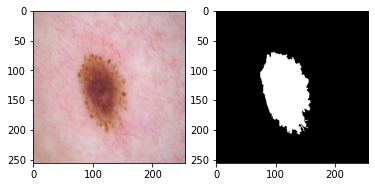

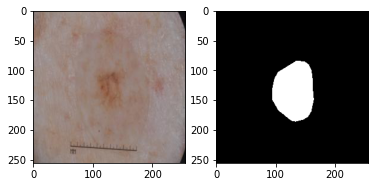

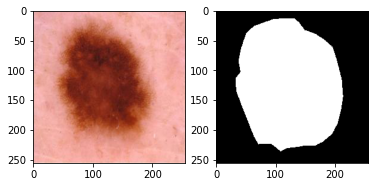

In [63]:
flow_args = {
    'batch_size': 32,
    'directory': 'dataset',
    'shuffle': True,
    'target_size': (256, 256),
    'class_mode': None,
    'subset': 'training',
    'seed': 1
}

train_generator = zip(
    image_generator.flow_from_directory(classes=['image'], **flow_args),
    mask_generator.flow_from_directory(classes=['mask'], **flow_args)
)

# Check images a
images, masks = next(train_generator)
for i, m in list(zip(images, masks))[:10]:
    _, axarr = plt.subplots(1,2)
    axarr[0].imshow((i*127.5+127.5).astype(np.int16))
    axarr[1].imshow(m)
    plt.show()